In [1]:
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.common.exceptions import NoSuchElementException
from selenium import webdriver

from graphviz import Digraph
import re

In [2]:
# prevent showing GUI with driver.
options = Options()
options.headless = True

# recommended way to set up the executable path of chrome driver.
service = Service(executable_path="/opt/homebrew/Caskroom/chromedriver/119.0.6045.105/chromedriver-mac-arm64/chromedriver")

driver = webdriver.Chrome(options=options, service=service)

In [3]:
url_list = [] # list to contain URLs to fetch HTML from
course_dict = {} # dict to save course object

In [4]:
# list of regex to extract necessary information

number3_pattern = r"\d{3}"
white_space_pattern = r'\s{2,}'
parenthesis_pattern = r"\([^()]*\)"
parenthesis_and_pattern = r"\([^)]*and[^)]*\)"
digit3_capital_pattern = r"([A-Z]\s*\w*\s*[A-Z]|[0-9]{3})"
name_element_pattern = r'\b[A-Z][A-Z/\s]*[A-Z]\b|[0-9]{3}'

In [5]:
class Course:
    def __init__(self, name, number):
        self.name = name
        self.number = number
        # contains all courses, regardless of 'and' and 'or'.
        self.requisite = set()
        # reflects 'and' and 'or'. tuple = 'and', list = 'or'.
        # each chunk separated with 'and' is list, meaning that its components are related 'or'.
        # but it is one of components of self.combination, meaning that each list should be fulfilled.
        # update: cannot deal with tuple... it's contradicting, but it should be implemented to be a list. very tragic.
        self.combination = []

In [6]:
#substitute target(default = "TO_BE_SUBSITITUED") in original with each element of substition_list.
# number of target in origianl should match the length of substitution_list!

def replace_with_list(original, substitution_list, target="TO_BE_SUBSTITUTED",):
    index = 0
    while original.find(target) != -1:
        original = original.replace(target, substitution_list[index], 1)
        index += 1
    return original

In [7]:
# for each requisite, remove link components.
def remove_link(text):
    
    # if there are some links, start removing it.
    if text.find("<a href=") != -1:
        
        # extract the course names in the requisite wittout link components.
        course = re.findall("title=(.*?)class", text)
        for i in range(len(course)):
            course[i] = course[i].replace("&nbsp;", " ").replace('"', "")
        
        # substitute placeholders with where there were originally course names with link components.
        substituted = re.sub("<a href(.*?)<\\/a>", "TO_BE_SUBSTITUTED", text)
        
        # go over placeholders and substitute it back with extracted course names without link components.
        # i = 0
        # while substituted.find("TO_BE_SUBSTITUTED") != -1:
        #     substituted = substituted.replace("TO_BE_SUBSTITUTED", course[i], 1)
        #     i += 1
        # return substituted
        
        # go over placeholders and substitute it back with extracted course names without link components.
        substituted = replace_with_list(substituted, course)
        return substituted
    
    # if there is no link, it is good to go.
    else:
        return text

In [8]:
# function that takes list of course subject and number and generates full course names using them.

def course_generator(text):
    subject = ''
    generated = False
    course_list = []
    for piece in text:
        
        # check whether the piece is nubmer or letter. 
        # if number, concatenate it to subject
        if re.match(number3_pattern, piece):
            course_list.append(subject + " " + piece)
            generated = True
        else:
            # if first letter, that's your subject.
            if subject == '' or generated == True:
                subject = piece
            # if not first letter, concatenate it with /, as it's multi-subject course.
            else:
                subject = subject + "/" + piece
                
    return course_list

In [9]:
# generate graph using course name to search in the course dictionary.
# recursively call itself in requisite courses to expand the graph.

def graph_generator(course_name, course_dict, graph, spread = set()):
    
    if course_name not in course_dict.keys() or course_name in spread:
        return
    
    # prevent infinite recursion.
    spread.add(course_name)
    requisities = course_dict[course_name].requisite 
    for requisite in requisities:

        graph.edge(course_name, requisite)
        graph_generator(requisite, course_dict, graph, spread)

In [10]:
# change the name! this is so misleading.
# remove all words that doesn't contain 3 numbers.

def num3(text, divider, join=True):

    text = text.split(divider)
    for i in range(len(text)):
        if len(re.findall(number3_pattern, text[i])) == 0:
            text[i] = ""
    if join == True:
        return ''.join(text)
    else:
        return text

In [11]:
# extract the class component that contains course name and course number.
def course_name_number_class(driver, course_name_list, course_number_list, course_dict):
    
    elements = driver.find_elements(By.CLASS_NAME, "courseblocktitle.noindent")
    for element in elements:
        # remove the unnecessary front part.
        rm_front = element.get_attribute("innerHTML").split('class="courseblockcode">')[1]
        # extract the course number.
        course_number = rm_front.replace("&nbsp;", " ").split("</span> —")[0]
        # replace all 2 white spaces to be a single white space and strip it.
        course_number = re.sub(white_space_pattern, " ", course_number).strip()
        # extract the course name.
        course_name = rm_front.split("</span> —")[1][:-9]
        
        # append coursenumber and name.
        course_number_list.append(course_number)
        course_name_list.append(course_name)
        
        # create an instance of class course and save it in dict with course number as a key.
        course_dict[course_number] = Course(course_name, course_number)

In [12]:
#extract requisite components that contain the requisite descriptions.

def extract_requisites(driver, requisites, description):
    elements = driver.find_elements(By.CLASS_NAME, "courseblockextra.noindent.clearfix")
    for element in elements:
        # collect only requisite components.
        if str(element.get_attribute("innerHTML").split(":")[0])[-10:] == "Requisites":
            requisite = element.get_attribute("innerHTML").split('<span class="cbextra-data">')[1][:-7]
            requisites.append(requisite)
    # for collected requisite, remove the link components and save in description.
    for requisite in requisites:
        description.append(remove_link(requisite))

In [13]:
# refine the requisite sentence.

# 2. remove unncessary sentences among the statement.
# 3. split each sentence by using divider 'and'. the length of list is the number of requisites. 


def refine_description(description):
    
    # first, separate a requisite chunk into each sentences.
    for i in range(len(description)):
        sentences = description[i].split(".")
        
        # second, go over each sentence to filter.
        for j in range(len(sentences)):
            
            # remove the sentence containing "not"
            # a sentence containing "not" doesn't contribute to describe required courses.
            if sentences[j].lower().find("not") != -1:
                sentences[j] = ""
                
            # remove sentence that doesn't contain number
            # a sentence without course numbers doesn't contribute to describe required courses.
            elif len(re.findall(number3_pattern, sentences[j])) == 0:
                sentences[j] = ""
            
            
            #replace 'and' with && in a part of sentence that is enclosed by parenthesis
            elif len(re.findall(parenthesis_and_pattern, sentences[j])) != 0:
                
                # find all parts of sentence that is encolsed by parenthesis
                converted = re.findall(parenthesis_and_pattern, sentences[j])
                
                # for each part found, replace 'and' with &&
                for k in range(len(converted)):
                    converted[k] = converted[k].replace("and", "&&")
                    
                # for each part in the original sentence, substitute it with the placeholder.
                sentences[j] = re.sub(parenthesis_and_pattern, "TO_BE_SUBSTITUTED", sentences[j])
                
                # go over placeholders and substitute it back with replaced parts in converted.
                sentences[j] = replace_with_list(sentences[j], converted, "TO_BE_SUBSTITUTED")

            #divide each case by and. each component is a component.
            sentences[j] = num3(sentences[j], "and", False)
            for k in range(len(sentences[j])):
                # divide and concatenate with various dividers, removing those and pieces that don't contain numbers
                sentences[j][k] = num3(sentences[j][k], ";")
                sentences[j][k] = num3(sentences[j][k], "or")
                sentences[j][k] = num3(sentences[j][k], ",")

        description[i] = sentences

In [14]:
# refine each component separated by 'and', store them in requisite list of each course.

def parse_and_save(description, course_number_list, course_dict):
# each course descrption
    for i in range(len(description)):
        
        # each sentence in a descrption
        for j in range(len(description[i])):

            # skip it if it contains nothing; it mean it has no number comment in a sentence
            if description[i][j] != ['']:

                # if it contains something related to number, that's the chuck we want to deal with.
                for k in range(len(description[i][j])):
                    description[i][j][k] = description[i][j][k].strip()
                    if description[i][j][k] == '':
                        pass
                    combination_chunk = []
    
                    # deal with those cases enclosed with () first.
                    if len(re.findall(parenthesis_pattern, description[i][j][k])) != 0:
                        parentheses = re.findall(parenthesis_pattern, description[i][j][k])
                        for parenthesis in parentheses:

                            # if it has &&, that means you need to take both courses. Deal with this special case by making it into tuple.
                            # once generated, add each course to requisite set and add the tuple to combination chunk list, which is a component of combination tuple.
                            if parenthesis.find("&&") != -1:
                                parenthesis = re.findall(name_element_pattern, parenthesis)
                                courses = tuple(course_generator(parenthesis))
                                for course in courses:
                                    course_dict[course_number_list[i]].requisite.add(course)
                                combination_chunk.append(courses)
                            
                            # typical 'or' list.
                            else:
                                parenthesis = re.findall(name_element_pattern, parenthesis)
                                courses = course_generator(parenthesis)
                                
                                for course in courses:
                                    course_dict[course_number_list[i]].requisite.add(course.strip())
                                    combination_chunk.append(course.strip())

                    # once dealing with () cases, replace their traces with '', and repeat the process.
                    description[i][j][k] = re.sub(parenthesis_pattern, "", description[i][j][k]).strip()
                    name_elements = re.findall(name_element_pattern, description[i][j][k])
                    courses = course_generator(name_elements)
                    for course in courses:
                        course_dict[course_number_list[i]].requisite.add(course.strip())
                        combination_chunk.append(course.strip())
                    if combination_chunk != []:
                        course_dict[course_number_list[i]].combination.append(combination_chunk)

In [15]:
url_list = ["https://guide.wisc.edu/courses/comp_sci/", "https://guide.wisc.edu/courses/math/"]

for url in url_list:
    
    course_name_list = []
    course_number_list = []
    requisites = []
    description = []
    
    driver.get(url)

    course_name_number_class(driver, course_name_list, course_number_list, course_dict)
    extract_requisites(driver, requisites, description)
    
    for requisite in description:
        print(requisite)
        print("\n")
    
    refine_description(description)
    parse_and_save(description, course_number_list, course_dict)

MATH 096 or placement into MATH 141 . MATH 118  does not fulfill the prerequisite. Not open to students with credit for COMP SCI 300  or COMP SCI 320 


Satisfied Quantitative Reasoning (QR) A requirement or declared in the Capstone Certificate in Computer Sciences for Professionals


Satisfied Quantitative Reasoning (QR) A requirement or declared in the Professional Capstone Program in Computer Sciences. Not open to students with credit for COMP SCI 301.


MATH 217 , MATH 221 , or MATH 275 


None


Not open to students with credit for COMP SCI 570 


Consent of instructor


Satisfied QR-A and (COMP SCI 200 , COMP SCI 220 , 302, COMP SCI 310 , 301, or placement into COMP SCI 300 ) or (E C E/​COMP SCI  252  and E C E 203 ); graduate/professional standing; declared in Capstone Certificate in COMP SCI. Not open to students with credit for COMP SCI 367.


Concurrent enrollment in COMP SCI 200  and member of Wisconsin Emerging Scholars program in Computer Science


MATH 222 , graduate/prof

In [16]:
for course in course_dict:
    print("course:" , course)
    print("requisites: ", course_dict[course].requisite)

course: COMP SCI/​L I S 102
requisites:  {'MATH 096', 'MATH 141'}
course: COMP SCI 200
requisites:  set()
course: COMP SCI 220
requisites:  set()
course: COMP SCI/​MATH 240
requisites:  {'MATH 217', 'MATH 275', 'MATH 221'}
course: COMP SCI/​E C E 252
requisites:  set()
course: COMP SCI 270
requisites:  set()
course: COMP SCI 298
requisites:  set()
course: COMP SCI 300
requisites:  {'COMP SCI 302', 'E C E/COMP SCI 252', 'COMP SCI 300', 'COMP SCI 200', 'COMP SCI 301', 'COMP SCI 220', 'COMP SCI 310', 'E C E 203'}
course: COMP SCI 304
requisites:  {'COMP SCI 200'}
course: COMP SCI 310
requisites:  {'MATH 222'}
course: COMP SCI 319
requisites:  set()
course: COMP SCI 320
requisites:  {'COMP SCI 319', 'COMP SCI 300', 'COMP SCI 301', 'COMP SCI 220', 'COMP SCI 202'}
course: COMP SCI/​E C E 352
requisites:  {'E C E/COMP SCI 252'}
course: COMP SCI/​E C E 354
requisites:  {'COMP SCI 302', 'E C E/COMP SCI 252', 'COMP SCI 300'}
course: COMP SCI 368
requisites:  set()
course: COMP SCI 400
requisites

In [17]:
course_dict.keys()

dict_keys(['COMP SCI/\u200bL I S 102', 'COMP SCI 200', 'COMP SCI 220', 'COMP SCI/\u200bMATH 240', 'COMP SCI/\u200bE C E 252', 'COMP SCI 270', 'COMP SCI 298', 'COMP SCI 300', 'COMP SCI 304', 'COMP SCI 310', 'COMP SCI 319', 'COMP SCI 320', 'COMP SCI/\u200bE C E 352', 'COMP SCI/\u200bE C E 354', 'COMP SCI 368', 'COMP SCI 400', 'COMP SCI 402', 'COMP SCI/\u200bSTAT 403', 'COMP SCI 407', 'COMP SCI 412', 'COMP SCI/\u200bI SY E/\u200bMATH 425', 'COMP SCI/\u200bE C E/\u200bMATH 435', 'COMP SCI/\u200bSTAT 471', 'COMP SCI/\u200bMATH/\u200bSTAT 475', 'COMP SCI/\u200bCURRIC 502', 'COMP SCI/\u200bE C E 506', 'COMP SCI/\u200bMATH 513', 'COMP SCI/\u200bMATH 514', 'COMP SCI/\u200bDS/\u200bI SY E 518', 'COMP SCI 520', 'COMP SCI/\u200bE C E/\u200bI SY E 524', 'COMP SCI/\u200bI SY E/\u200bMATH/\u200bSTAT 525', 'COMP SCI/\u200bI SY E 526', 'COMP SCI/\u200bE C E/\u200bM E 532', 'COMP SCI/\u200bE C E 533', 'COMP SCI 534', 'COMP SCI 536', 'COMP SCI 537', 'COMP SCI 538', 'COMP SCI/\u200bE C E/\u200bM E 539', '

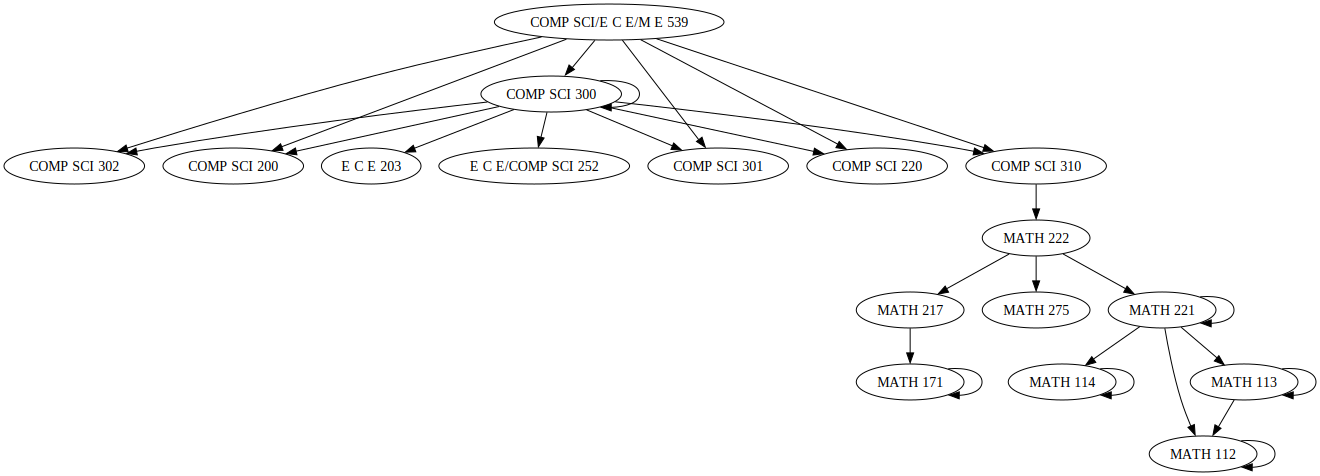

In [18]:
g = Digraph(strict=True)

graph_generator('COMP SCI/​E C E/​M E 539', course_dict, g)
g

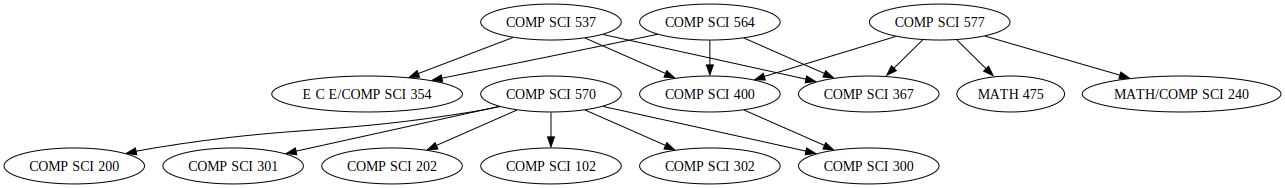

In [19]:
g = Digraph(strict=True)

input_list = ['COMP SCI 564', 'COMP SCI 537', 'COMP SCI 577', 'COMP SCI 570']
for course in input_list:
    graph_generator(course, course_dict, g)
g

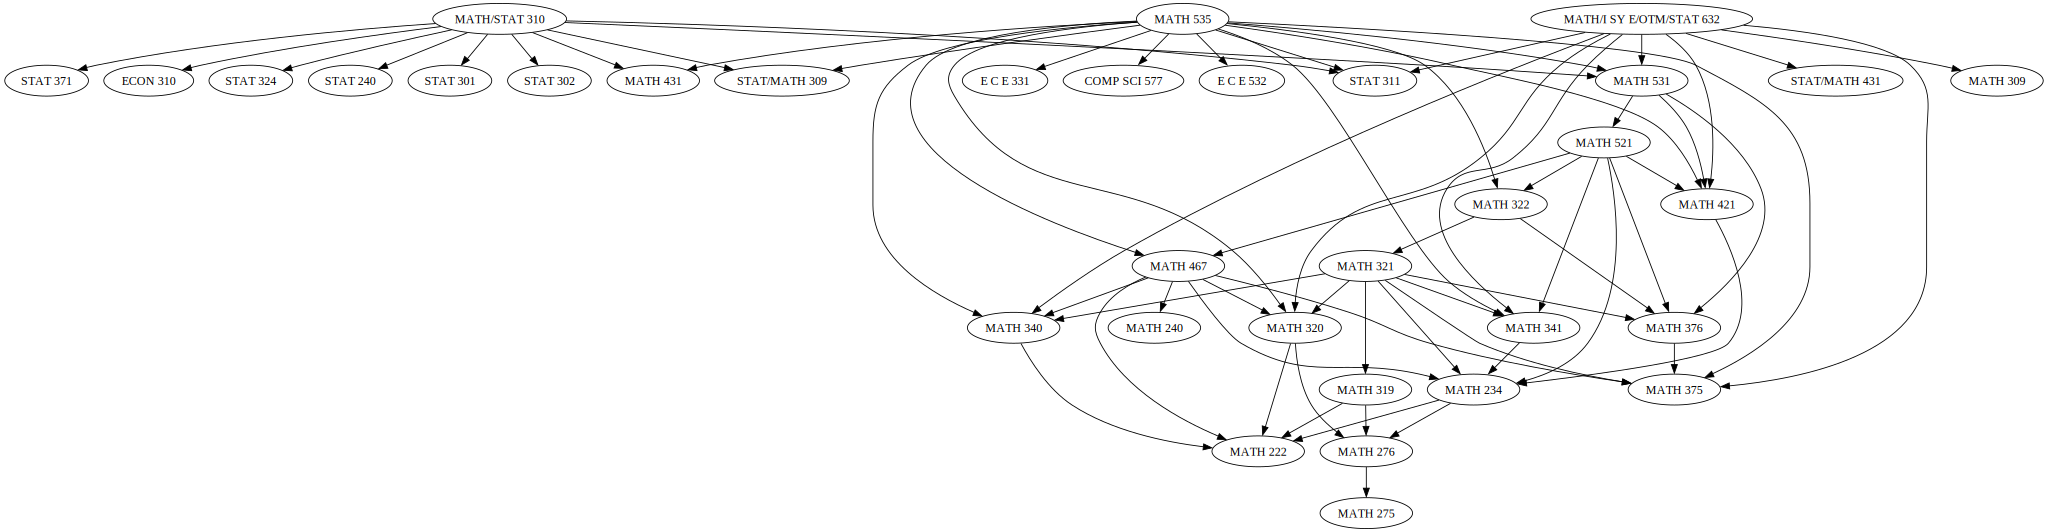

In [20]:
g = Digraph(strict=True)

input_list = ['MATH/​STAT 310', 'MATH/​I SY E/​OTM/​STAT 632', 'MATH 535']
for course in input_list:
    graph_generator(course, course_dict, g)
g